<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=25% ALIGN="right">
</figure>

<p><div> 
<br><b>Monitoring of Structural Health and Geohazards</b>
<br><b>CEGM2008</b>
<br> Faculty of Civil Engineering and Geosciences - Delft University of Technology 
<br><b>Responsible instructor:</b>
<br><i>- Eliz-Mari Lourens</i>
</div>
<br><b>Notebooks created by teaching assistants:</b>
<br><i>- Siemen Algra</i>
<br><i>- Heisuke Miyoshi</i>
</div>


# 3.3 Model updating

In this notebook you will identify the Young's modulus of the beam by minimising the difference between a set of calculated modal properties and the set you identified from the vibration data.

NOTE: Make sure you have get_prop.py saved in the same location as this notebook. This is a custom package that calculates the modal properties as a function of the elasticity modulus of the beam.

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Importing the Python file to obtain eigenfrequencies and eigenmodes given the parameter to be optimized
from get_prop import get_prop

In [2]:
# Importing identified eigenfrequencies and eigenmodes from workshop 3.2
# Specify the path to the folder where the identified eigenfrequencies and eigenmodes are stored
path_file = "output_system_identification/"

omega_id = np.loadtxt(path_file + "omega_id.txt", dtype = float)
Phi_id = np.loadtxt(path_file + "phi_id.txt", dtype = float)
ind_id = np.loadtxt(path_file + "ind_id.txt", dtype = int)

In [3]:
print(omega_id)

[  20.6  127.   369.   731.  1207. ]


In [4]:
print(Phi_id)

[[-0.0072834  -0.06143174 -0.12871673 -0.20873822 -0.28571662]
 [-0.03471699 -0.17440261 -0.33956572 -0.41166248 -0.34161329]
 [-0.07929584 -0.30243667 -0.42051356 -0.22880119  0.12051484]
 [-0.12939766 -0.40352642 -0.2920755   0.1840261   0.36538239]
 [-0.19199045 -0.42337014 -0.00884667  0.39094452 -0.01561056]
 [-0.25788443 -0.34983661  0.26884196  0.16111555 -0.38172145]
 [-0.33924893 -0.21432044  0.369598   -0.23611175 -0.10521575]
 [-0.416495    0.01014722  0.22265182 -0.34977216  0.33960839]
 [-0.49337845  0.26215764 -0.13399311 -0.00100821  0.13294768]
 [-0.58340824  0.54324726 -0.57402304  0.58639628 -0.60299585]]


In [5]:
print(ind_id)

[ 2  6 10 14 18 22 26 30 34 38]


## Definition of the cost function

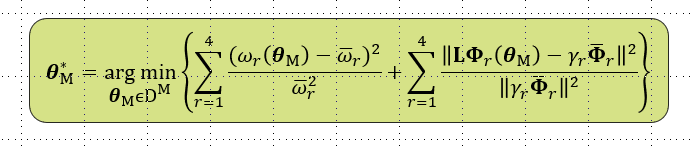

In [6]:
def cost_func(E, omega_id, Phi_id):
    """
    This function calculates the objective function for the optimisation problem
    Input:
        E: Young's modulus    [Pa]
        omega_id: Identified eigenfrequencies - list of 5 values [Hz]
        Phi_id: Identified eigenvectors - 10x5 matrix
    Output:
        obj: Objective function value
    """
   
    # Get the modelled eigenfrequencies and modes from the custom package
    Phi_m, omega_m = get_prop(E)
    n_modes = 5
    # Choose how many modes to use in the optimization
    omega_m = omega_m[:n_modes]
    Phi_m = Phi_m[ind_id, :n_modes]
    
    T1 = np.zeros((len(omega_m),))        # First term of the cost function
    T2 = np.zeros((len(omega_m),))        # Second term of the cost function

    for i in range(len(omega_m)):
        
        # First term
        T1[i] = (omega_m[i] - omega_id[i])**2 / (omega_id[i]**2)
        
        # Normalise eigenmodes and ensure they have the same sign 
        Phi_m[:,i] = Phi_m[:,i] / np.linalg.norm(Phi_m[:,i])
        inprod = np.dot(Phi_id[:, i], Phi_m[:, i])
        #inprod = Phi_id[:,i].T * Phi_m[:,i]
        Phi_m[:,i] = np.sign(inprod) * Phi_m[:,i]
        gamma = np.dot(Phi_id[:, i], Phi_m[:, i]) / np.dot(Phi_id[:, i], Phi_id[:, i])   # LS-optimal scaling
        #gamma = 1
        # Second term

        T2[i] = np.linalg.norm(Phi_m[:,i] - gamma * Phi_id[:,i])**2 / np.linalg.norm(gamma * Phi_id[:,i])**2
    
    # The objective function is the summation of T1 and T2
    obj = np.sum(T1) + np.sum(T2)
    
    return obj

### Note: Algorithm for the optimisation
For the optimisation, the "fmin" function from scipy.optimize will be used. This function uses the Nelder-Mead simplex algorithm to find the minimum of the objective function. This algorithm is a heuristic method and is capable of optimising a multi-parameter function. Also, this algorithm only uses the objective function and does not use the derivatives or the second derivatives of the objective function, which allows for complex objective functions to be optimised. The convergence of the optimisation will be set by satisfying the upper limit of absolute errors of both the variables and the function value.  

For more information about the python code, check the document of scipy  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html

For more information about the algorithm, check the page of scholarpedia as intro  
http://www.scholarpedia.org/article/Nelder-Mead_algorithm

In [7]:
# Initial guess of the parameter
x0 = 2.0e11    # [Pa]

# "xstar" is the optimum and "progress" stores the parameter of each iteration
x_star, progress = optimize.fmin(cost_func, x0, args=(omega_id, Phi_id), retall=1)
print(f"The optimum parameter is {format(x_star[0], '.3E')} [Pa]")

Optimization terminated successfully.
         Current function value: 0.014778
         Iterations: 49
         Function evaluations: 122
The optimum parameter is 2.068E+11 [Pa]


In [8]:
# Storing the intermediate solutions of the fmin function
iterations = int(len(progress))
mid_sol = np.reshape(np.array(progress[:-1]), (iterations-1,))

# Calculating the objective function values for the intermediate solutions
min_results = np.zeros(mid_sol.shape)
for i, k in enumerate(mid_sol):
    min_results[i] = cost_func(k, omega_id, Phi_id)

In [9]:
# Brute force algorithm (trying all possible values of the parameter)
e_array = np.arange(150e9, 300e9, 1e9)
results = np.zeros(e_array.shape)
for i, k in enumerate(e_array):
    results[i] = cost_func(k, omega_id, Phi_id)

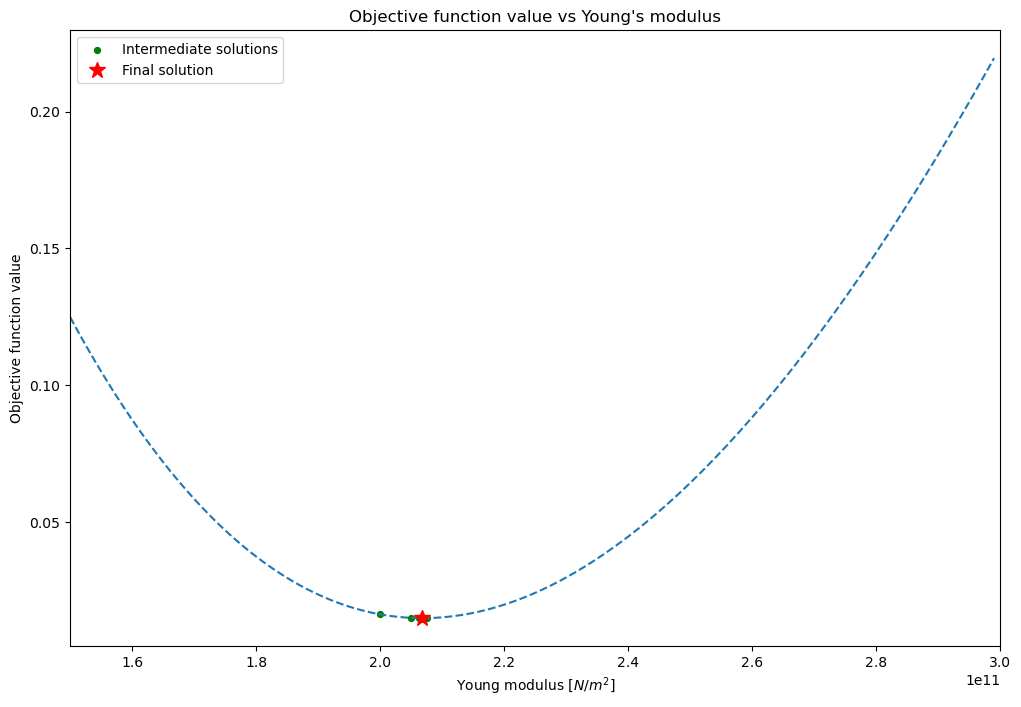

In [10]:
# Plotting the result of the optimisation
plt.figure(figsize=(12,8))
plt.title("Objective function value vs Young's modulus")
plt.plot(e_array, results, '--')                               # plot objective function values for all possible parameter values (brute force method)
plt.scatter(mid_sol, min_results, 
            c='g', s=18, label="Intermediate solutions")       # plotting the intermediate solutions of the optimisation
plt.plot(progress[-1],cost_func(progress[-1], omega_id, Phi_id),
         'r*', markersize=12, label="Final solution")          # Plotting the final solution (optimum)

# figure properties
plt.xlabel("Young modulus $[N/m^2]$")
plt.ylabel("Objective function value")
plt.legend()
plt.xlim(1.5e11, 3.0e11);

What changes if you have multiple parameters?

